In [5]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.metrics import fbeta_score, classification_report
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
customer_df=pd.read_csv('./Churn_Modelling.csv')

In [4]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
customer_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
# Step 1: Dropping unnecessary columns
customer_df = customer_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [7]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
# Step 2: One-Hot Encoding for categorical features
X = customer_df.drop('Exited', axis=1)
y = customer_df['Exited']

In [9]:
# OneHotEncoding
categorical_features = ['Geography', 'Gender']
encoder = ColumnTransformer([('onehot', OneHotEncoder(drop='first'), categorical_features)], remainder='passthrough')


In [10]:
# Step 3: Check if normalization or scaling is required and perform it
scaler = StandardScaler()

In [11]:
# Splitting data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
# Defining the models to be used
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

In [13]:
# Defining sampling methods
sampling_methods = {
    'No Sampling': None,
    'SMOTE': SMOTE(random_state=42),
    'Borderline-SMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42)
}

In [14]:
# Initializing a dataframe to store results
results_df = pd.DataFrame(columns=['Model', 'Sampling', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'F2-Score', 'ROC-AUC'])


In [16]:
# List to store results
results_list = []

# Step 4: Building models and evaluating them
for sampling_name, sampler in sampling_methods.items():
    for model_name, model in models.items():
        if sampler:
            pipe = ImbPipeline(steps=[('encoder', encoder), ('scaler', scaler), ('sampler', sampler), ('model', model)])
        else:
            pipe = Pipeline(steps=[('encoder', encoder), ('scaler', scaler), ('model', model)])
        
        # Training the model
        pipe.fit(X_train, y_train)
        
        # Predictions and evaluation
        y_pred = pipe.predict(X_test)
        y_prob = pipe.predict_proba(X_test)[:, 1]

        # Calculating metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        f2 = fbeta_score(y_test, y_pred, beta=2)
        roc_auc = roc_auc_score(y_test, y_prob)

        # Appending results to the list
        results_list.append({
            'Model': model_name,
            'Sampling': sampling_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'F2-Score': f2,
            'ROC-AUC': roc_auc
        })

# Converting list to DataFrame
results_df = pd.DataFrame(results_list)




In [17]:
results_df

,Model,Sampling,Accuracy,Precision,Recall,F1-Score,F2-Score,ROC-AUC
0,Decision Tree,No Sampling,0.7835,0.470721,0.513514,0.491187,0.504344,0.682997
1,Naive Bayes,No Sampling,0.8200,0.600000,0.346437,0.439252,0.378422,0.784287
2,Logistic Regression,No Sampling,0.8080,0.589147,0.186732,0.283582,0.216278,0.774766
3,Random Forest,No Sampling,0.8620,0.763052,0.466830,0.579268,0.506127,0.854088
4,SVM,No Sampling,0.8610,0.834197,0.395577,0.536667,0.442065,0.826924
5,XGBoost,No Sampling,0.8530,0.696864,0.491400,0.576369,0.522193,0.829285
6,Decision Tree,SMOTE,0.7660,0.437372,0.523342,0.476510,0.503546,0.675670
7,Naive Bayes,SMOTE,0.7135,0.385042,0.683047,0.492471,0.591489,0.787455
8,Logistic Regression,SMOTE,0.7155,0.389041,0.697789,0.499560,0.602205,0.776879
9,Random Forest,SMOTE,0.8445,0.623711,0.594595,0.608805,0.600198,0.848350


In [21]:
# lets check XG_boost
# Let's check XGBoost results
xgboost_results = results_df[results_df['Model'] == "XGBoost"]
xgboost_results

,Model,Sampling,Accuracy,Precision,Recall,F1-Score,F2-Score,ROC-AUC
5,XGBoost,No Sampling,0.8530,0.696864,0.491400,0.576369,0.522193,0.829285
11,XGBoost,SMOTE,0.8515,0.658046,0.562654,0.606623,0.579453,0.838021
17,XGBoost,Borderline-SMOTE,0.8395,0.621469,0.540541,0.578187,0.554995,0.835507
23,XGBoost,ADASYN,0.8355,0.607735,0.540541,0.572172,0.552764,0.840677
29,XGBoost,SMOTEENN,0.8160,0.536178,0.710074,0.610994,0.666820,0.850825


In [23]:
randomforest_results = results_df[results_df['Model'] == "Random Forest"]
randomforest_results

,Model,Sampling,Accuracy,Precision,Recall,F1-Score,F2-Score,ROC-AUC
3,Random Forest,No Sampling,0.8620,0.763052,0.466830,0.579268,0.506127,0.854088
9,Random Forest,SMOTE,0.8445,0.623711,0.594595,0.608805,0.600198,0.848350
15,Random Forest,Borderline-SMOTE,0.8400,0.605327,0.614251,0.609756,0.612445,0.850498
21,Random Forest,ADASYN,0.8415,0.607143,0.626536,0.616687,0.622559,0.843087
27,Random Forest,SMOTEENN,0.7920,0.492537,0.729730,0.588119,0.665621,0.850495


In [32]:
SVM_results = results_df[results_df['Model'] == "SVM"]
SVM_results

,Model,Sampling,Accuracy,Precision,Recall,F1-Score,F2-Score,ROC-AUC
4,SVM,No Sampling,0.8610,0.834197,0.395577,0.536667,0.442065,0.826924
10,SVM,SMOTE,0.7935,0.494949,0.722359,0.587413,0.661566,0.838758
16,SVM,Borderline-SMOTE,0.7575,0.443314,0.749386,0.557078,0.658463,0.834551
22,SVM,ADASYN,0.7460,0.429764,0.759214,0.548845,0.658287,0.830755
28,SVM,SMOTEENN,0.7420,0.428384,0.800983,0.558219,0.682294,0.837513


In [24]:
# Filter the DataFrame to get only rows where Sampling is "SMOTEENN"
smoteenn_results = results_df[results_df['Sampling'] == "SMOTEENN"]

# Displaying the filtered results
print(smoteenn_results)


                  Model  Sampling  Accuracy  Precision    Recall  F1-Score  \
24        Decision Tree  SMOTEENN    0.7695   0.458462  0.732187  0.563860   
25          Naive Bayes  SMOTEENN    0.6600   0.345413  0.749386  0.472868   
26  Logistic Regression  SMOTEENN    0.6500   0.340934  0.771499  0.472892   
27        Random Forest  SMOTEENN    0.7920   0.492537  0.729730  0.588119   
28                  SVM  SMOTEENN    0.7420   0.428384  0.800983  0.558219   
29              XGBoost  SMOTEENN    0.8160   0.536178  0.710074  0.610994   

    F2-Score   ROC-AUC  
24  0.654083  0.755610  
25  0.607328  0.773458  
26  0.615928  0.771445  
27  0.665621  0.850495  
28  0.682294  0.837513  
29  0.666820  0.850825  


In [25]:
smoteenn_results

,Model,Sampling,Accuracy,Precision,Recall,F1-Score,F2-Score,ROC-AUC
24,Decision Tree,SMOTEENN,0.7695,0.458462,0.732187,0.563860,0.654083,0.755610
25,Naive Bayes,SMOTEENN,0.6600,0.345413,0.749386,0.472868,0.607328,0.773458
26,Logistic Regression,SMOTEENN,0.6500,0.340934,0.771499,0.472892,0.615928,0.771445
27,Random Forest,SMOTEENN,0.7920,0.492537,0.729730,0.588119,0.665621,0.850495
28,SVM,SMOTEENN,0.7420,0.428384,0.800983,0.558219,0.682294,0.837513
29,XGBoost,SMOTEENN,0.8160,0.536178,0.710074,0.610994,0.666820,0.850825


In [1]:
import pandas as pd

# Create a DataFrame with the given data
data = {
    'Model': ['Decision Tree', 'Naive Bayes', 'Logistic Regression',  'SVM','Random Forest', 'XGBoost'],
    'Sampling': ['SMOTEENN'] * 6,
    'Accuracy': [0.7695, 0.6600, 0.6500, 0.7390, 0.7920, 0.6335],
    'Precision': [0.458462, 0.345413, 0.340934, 0.424242, 0.492537, 0.342967],
    'Recall': [0.732187, 0.749386, 0.771499, 0.791155, 0.729730, 0.874693],
    'F1-Score': [0.563860, 0.472868, 0.472892, 0.552316, 0.588119, 0.492734],
    'F2-Score': [0.654083, 0.607328, 0.615928, 0.674487, 0.665621, 0.6676667],
    'ROC-AUC': [0.755610, 0.773458, 0.771445, 0.838427, 0.850495, 0.843514]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Analysis: Determine the best model based on key metrics
best_accuracy = df.loc[df['Accuracy'].idxmax()]
best_precision = df.loc[df['Precision'].idxmax()]
best_recall = df.loc[df['Recall'].idxmax()]
best_f1_score = df.loc[df['F1-Score'].idxmax()]
best_f2_score = df.loc[df['F2-Score'].idxmax()]
best_roc_auc = df.loc[df['ROC-AUC'].idxmax()]

# Print the best models for each metric
print("\nBest Model by Accuracy:\n", best_accuracy)
print("\nBest Model by Precision:\n", best_precision)
print("\nBest Model by Recall:\n", best_recall)
print("\nBest Model by F1-Score:\n", best_f1_score)
print("\nBest Model by F2-Score:\n", best_f2_score)
print("\nBest Model by ROC-AUC:\n", best_roc_auc)

# # Optional: Save the DataFrame to a CSV file
# df.to_csv('model_performance_metrics.csv', index=False)


                 Model  Sampling  Accuracy  Precision    Recall  F1-Score  \
0        Decision Tree  SMOTEENN    0.7695   0.458462  0.732187  0.563860   
1          Naive Bayes  SMOTEENN    0.6600   0.345413  0.749386  0.472868   
2  Logistic Regression  SMOTEENN    0.6500   0.340934  0.771499  0.472892   
3                  SVM  SMOTEENN    0.7390   0.424242  0.791155  0.552316   
4        Random Forest  SMOTEENN    0.7920   0.492537  0.729730  0.588119   
5              XGBoost  SMOTEENN    0.6335   0.342967  0.874693  0.492734   

   F2-Score   ROC-AUC  
0  0.654083  0.755610  
1  0.607328  0.773458  
2  0.615928  0.771445  
3  0.674487  0.838427  
4  0.665621  0.850495  
5  0.667667  0.843514  

Best Model by Accuracy:
 Model        Random Forest
Sampling          SMOTEENN
Accuracy             0.792
Precision         0.492537
Recall             0.72973
F1-Score          0.588119
F2-Score          0.665621
ROC-AUC           0.850495
Name: 4, dtype: object

Best Model by Precision:
 

In [2]:
df


,Model,Sampling,Accuracy,Precision,Recall,F1-Score,F2-Score,ROC-AUC
0,Decision Tree,SMOTEENN,0.7695,0.458462,0.732187,0.563860,0.654083,0.755610
1,Naive Bayes,SMOTEENN,0.6600,0.345413,0.749386,0.472868,0.607328,0.773458
2,Logistic Regression,SMOTEENN,0.6500,0.340934,0.771499,0.472892,0.615928,0.771445
3,SVM,SMOTEENN,0.7390,0.424242,0.791155,0.552316,0.674487,0.838427
4,Random Forest,SMOTEENN,0.7920,0.492537,0.729730,0.588119,0.665621,0.850495
5,XGBoost,SMOTEENN,0.6335,0.342967,0.874693,0.492734,0.667667,0.843514


## Bar Plot

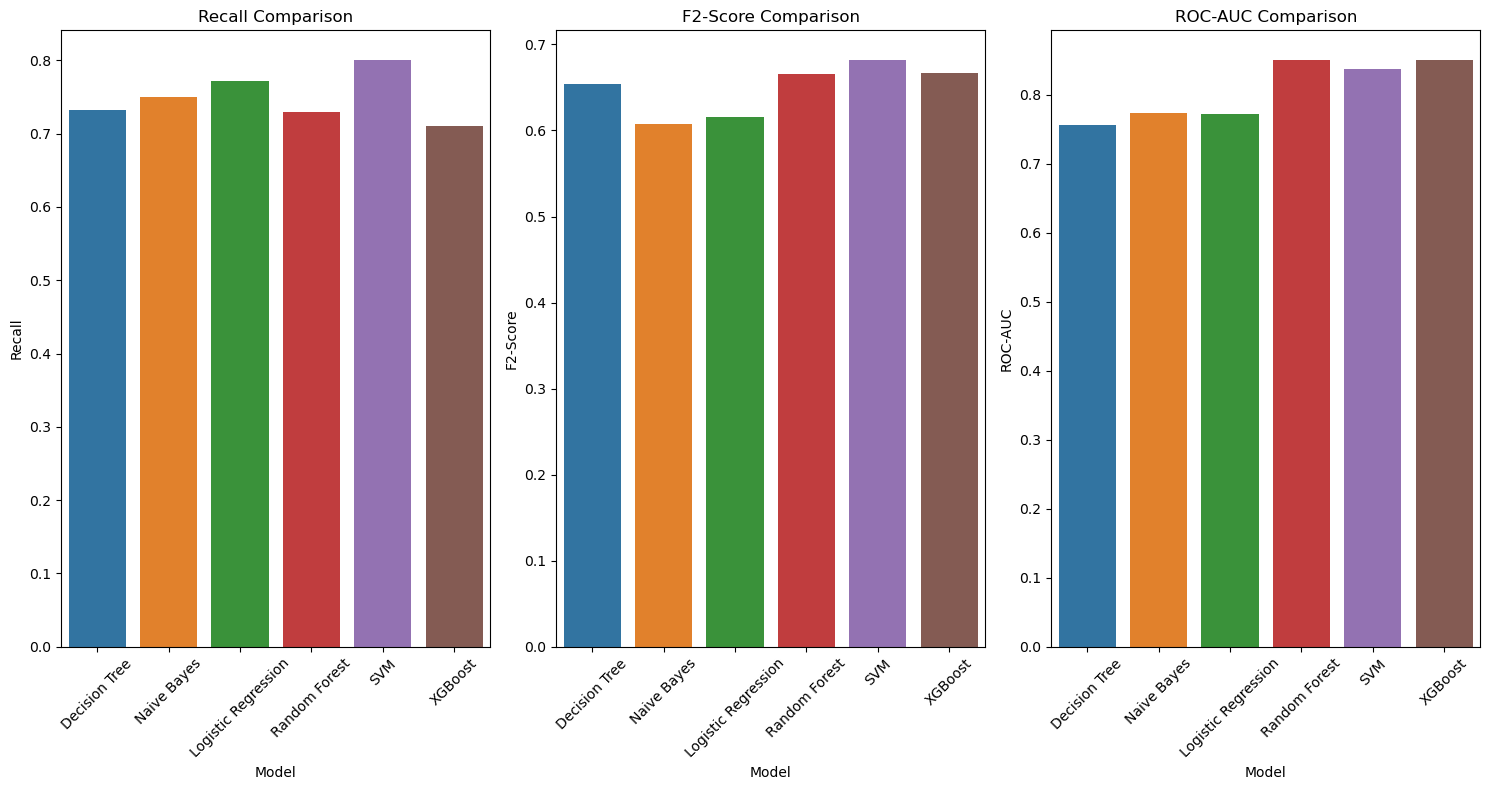

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure and axes
plt.figure(figsize=(15, 8))

# Plot Recall
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='Recall', data=smoteenn_results)
plt.title('Recall Comparison')
plt.xticks(rotation=45)

# Plot F2-Score
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='F2-Score', data=smoteenn_results)
plt.title('F2-Score Comparison')
plt.xticks(rotation=45)

# Plot ROC-AUC
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='ROC-AUC', data=smoteenn_results)
plt.title('ROC-AUC Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Grouped Bar Plot

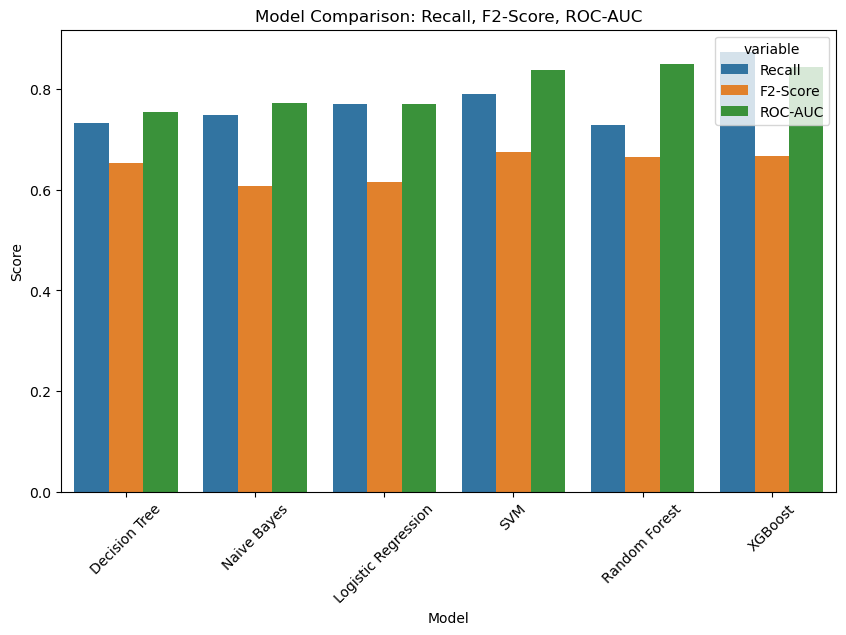

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Melt the DataFrame to have a long-form DataFrame suitable for grouped bar plot
melted_results = df.melt(id_vars='Model', value_vars=['Recall', 'F2-Score', 'ROC-AUC'])

# Grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='value', hue='variable', data=melted_results)
plt.title('Model Comparison: Recall, F2-Score, ROC-AUC')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()


## Radar Chart

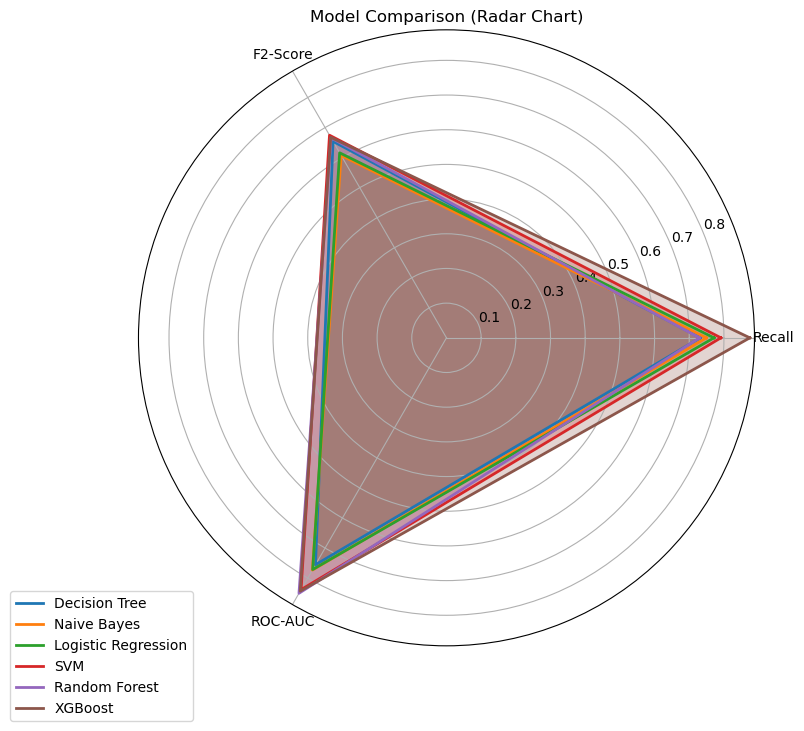

In [10]:
from math import pi

# Categories (metrics)
categories = ['Recall', 'F2-Score', 'ROC-AUC']

# Number of variables
N = len(categories)

# Set up the radar chart
plt.figure(figsize=(10, 8))
for i in range(len(df)):
    values = df.iloc[i][categories].values.flatten().tolist()
    values += values[:1]  # To close the circle
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=df.iloc[i]['Model'])
    ax.fill(angles, values, alpha=0.25)

plt.title('Model Comparison (Radar Chart)')
plt.xticks(angles[:-1], categories)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


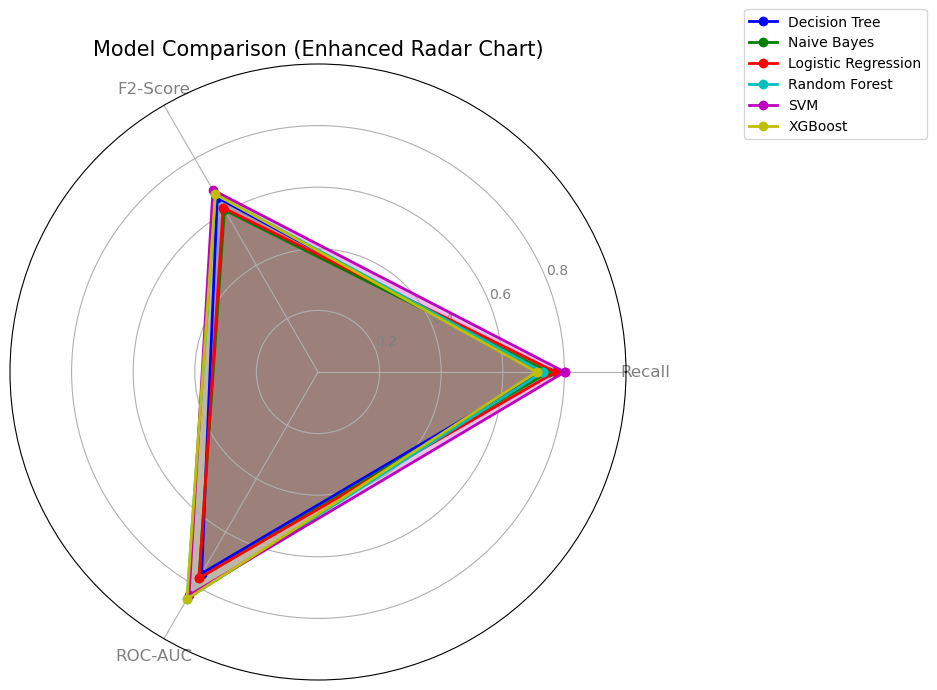

In [31]:
from math import pi
import matplotlib.pyplot as plt

# Categories (metrics)
categories = ['Recall', 'F2-Score', 'ROC-AUC']
N = len(categories)

# Set up the radar chart
plt.figure(figsize=(10, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Distinct colors for each model

for i, color in enumerate(colors[:len(smoteenn_results)]):
    values = smoteenn_results.iloc[i][categories].values.flatten().tolist()
    values += values[:1]  # To close the circle
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Plot each model with distinct color and line settings
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid', label=smoteenn_results.iloc[i]['Model'], marker='o')
    ax.fill(angles, values, color=color, alpha=0.25)

# Customize the chart
plt.title('Model Comparison (Enhanced Radar Chart)', size=15)
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
plt.ylim(0, 1)

# Add a legend outside the plot for clarity
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.1))

# Show the plot
plt.show()
